### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [2]:
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

NumPy version: 1.26.4
Pandas version: 2.2.3


### Load and Prepare Data

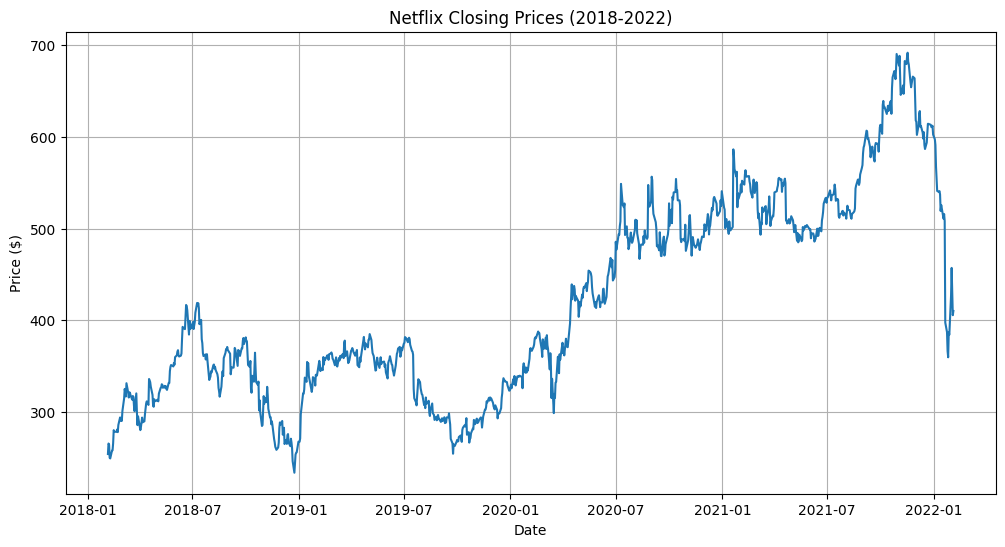

In [3]:
# Load data
path = r"C:\Users\ADMIN\Desktop\Stock-Price-Forecasting-System-Using-Apache-Spark\data\raw\NFLX.csv"
df = pd.read_csv(path, parse_dates=['Date'], index_col='Date')
df.sort_index(inplace=True)

# Use 'Close' prices
ts = df['Close']

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(ts)
plt.title('Netflix Closing Prices (2018-2022)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid()
plt.show()

## Check Stationarity

In [4]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(trends):
    result = adfuller(trends)
    labels = ['ADF Test Statistic','p-value','#Lags Used','#Observation Used']
    for value,label in zip(result,labels):
        print(label  + ': ' + str(value))
    if result[1]<=0.05:
        print('Strong evidence against the null hypothesis, Hence REJECT Ho. and The series is Stationary')
    else:
        print('week evidence against null hypothesis, Hence ACCEPT Ho. that the series is not stationary.')
        
adfuller_test(df['Close'])

ADF Test Statistic: -1.812590687828996
p-value: 0.3742289256820758
#Lags Used: 6
#Observation Used: 1002
week evidence against null hypothesis, Hence ACCEPT Ho. that the series is not stationary.


Conclusion: The series is non-stationary (p-value > 0.05). Apply differencing.

## First Differencing

In [5]:
df = df.groupby('Date')['Close'].sum().reset_index()
df.Date=pd.to_datetime(df.Date)
df.head()

,Date,Close
0,2018-02-05,254.259995
1,2018-02-06,265.720001
2,2018-02-07,264.559998
3,2018-02-08,250.100006
4,2018-02-09,249.470001


In [6]:
df.set_index(['Date'],inplace=True)
df.head()

,Close
Date,
2018-02-05,254.259995
2018-02-06,265.720001
2018-02-07,264.559998
2018-02-08,250.100006
2018-02-09,249.470001


ADF Test Statistic: -14.242275992929116
p-value: 1.5304022754298515e-26
#Lags Used: 5
#Observation Used: 1002
Strong evidence against the null hypothesis, Hence REJECT Ho. and The series is Stationary


<Axes: xlabel='Date'>

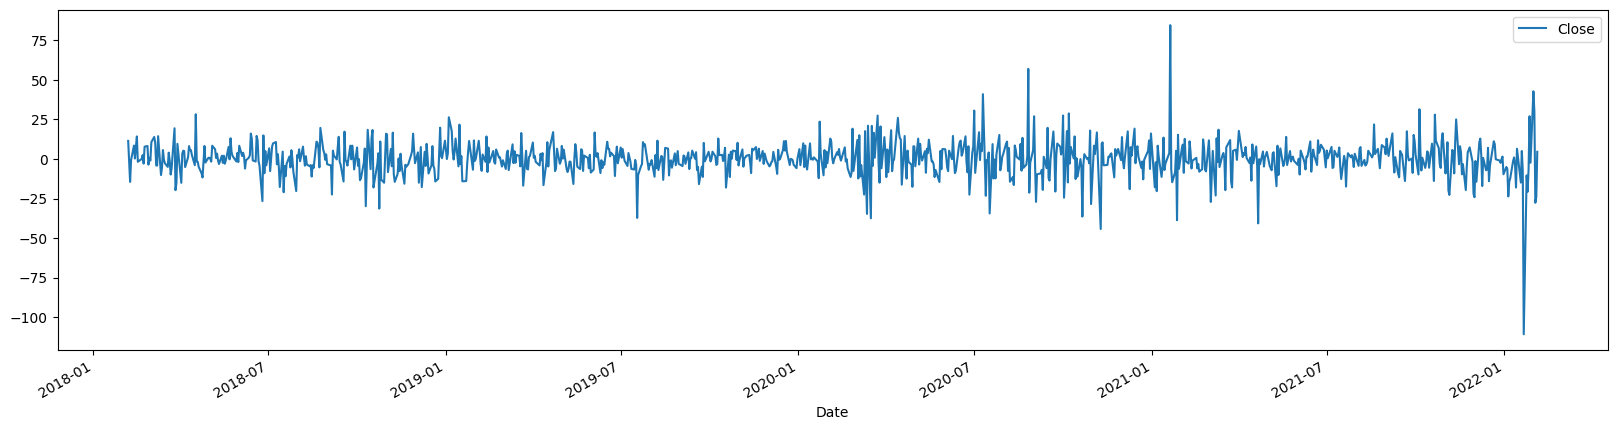

In [7]:
diff1=df-df.shift(1)
diff1=diff1.dropna()
adfuller_test(diff1)
diff1.plot(figsize=(20,5))

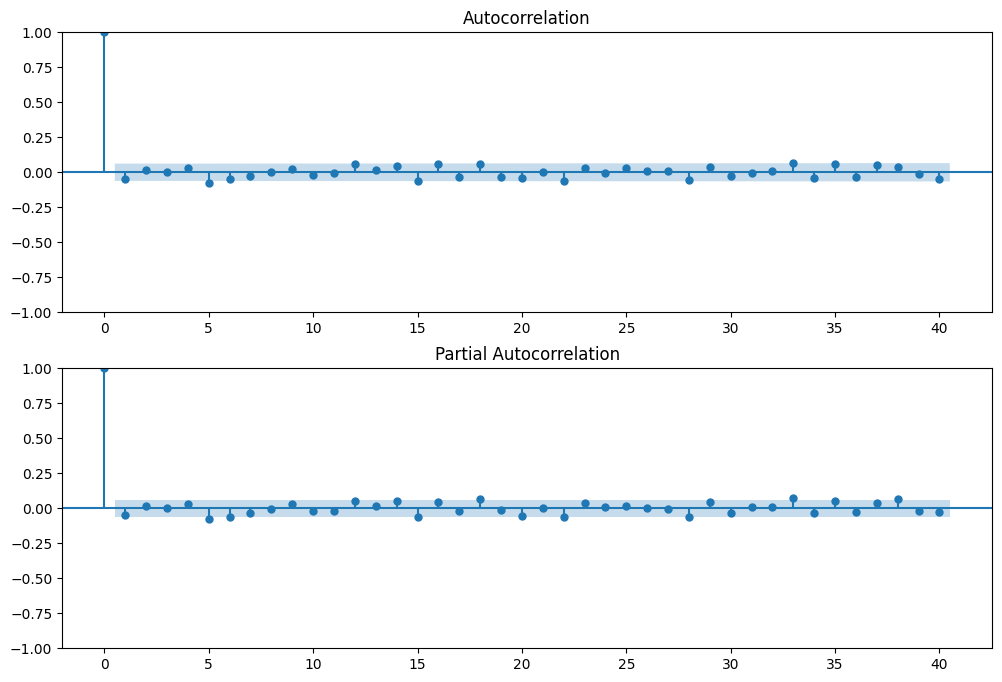

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(diff1, lags=40, ax=ax1)
plot_pacf(diff1, lags=40, ax=ax2)
plt.show()

In [11]:
for i in range(1,7):
    for j in range(1,7):
        model=ARIMA(df['Close'],order=(i,0,j))
        result=model.fit()
        print(f"AIC :{result.aic}, Order Of AR: {i}, Order of MA:{j} ") 

AIC :7719.252725395365, Order Of AR: 1, Order of MA:1 
AIC :7720.890983925257, Order Of AR: 1, Order of MA:2 
AIC :7722.748629699471, Order Of AR: 1, Order of MA:3 
AIC :7723.6857618954, Order Of AR: 1, Order of MA:4 
AIC :7718.415482130338, Order Of AR: 1, Order of MA:5 
AIC :7718.172317927726, Order Of AR: 1, Order of MA:6 
AIC :7719.8768504040345, Order Of AR: 2, Order of MA:1 
AIC :7723.2513517895395, Order Of AR: 2, Order of MA:2 
AIC :7724.674017271109, Order Of AR: 2, Order of MA:3 
AIC :7723.762865568256, Order Of AR: 2, Order of MA:4 
AIC :7718.2875663978975, Order Of AR: 2, Order of MA:5 
AIC :7720.069487585959, Order Of AR: 2, Order of MA:6 
AIC :7721.431356139279, Order Of AR: 3, Order of MA:1 
AIC :7714.694167711428, Order Of AR: 3, Order of MA:2 
AIC :7725.176500000007, Order Of AR: 3, Order of MA:3 
AIC :7720.5914593697225, Order Of AR: 3, Order of MA:4 
AIC :7719.9706583347515, Order Of AR: 3, Order of MA:5 
AIC :7722.088940691343, Order Of AR: 3, Order of MA:6 
AIC :77

In [12]:
model=ARIMA(df['Close'],order=(6,1,6))
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1009
Model:                 ARIMA(6, 1, 6)   Log Likelihood               -3838.361
Date:                Mon, 24 Feb 2025   AIC                           7702.723
Time:                        22:58:13   BIC                           7766.627
Sample:                             0   HQIC                          7727.002
                               - 1009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2226      0.065      3.446      0.001       0.096       0.349
ar.L2          0.6265      0.062     10.133      0.000       0.505       0.748
ar.L3         -1.1328      0.069    -16.523      0.000      -1.267      -0.998
ar.L4          0.5391      0.062      8.661      0.000       0.417       0.661
ar.L5          0.2455      0.056      4.349      0.000       0.135       0.356
ar.L6         -0.8750      0.065    -13.538      0.000      -1.002      -0.748
ma.L1         -0.2625      0.074     -3.541      0.000      -0.408      -0.117
ma.L2         -0.5879      0.068     -8.670      0.000      -0.721      -0.455
ma.L3          1.1596      0.070     16.449      0.000       1.021       1.298
ma.L4         -0.5767      0.065     -8.885      0.000      -0.704      -0.449
ma.L5         -0.2654      0.065     -4.061      0.000      -0.394      -0.137
ma.L6          0.8398      0.073     11.531      0.000       0.697       0.982
sigma2       120.4550      2.382     50.560      0.000     115.785     125.124
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              9330.07
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Date'>

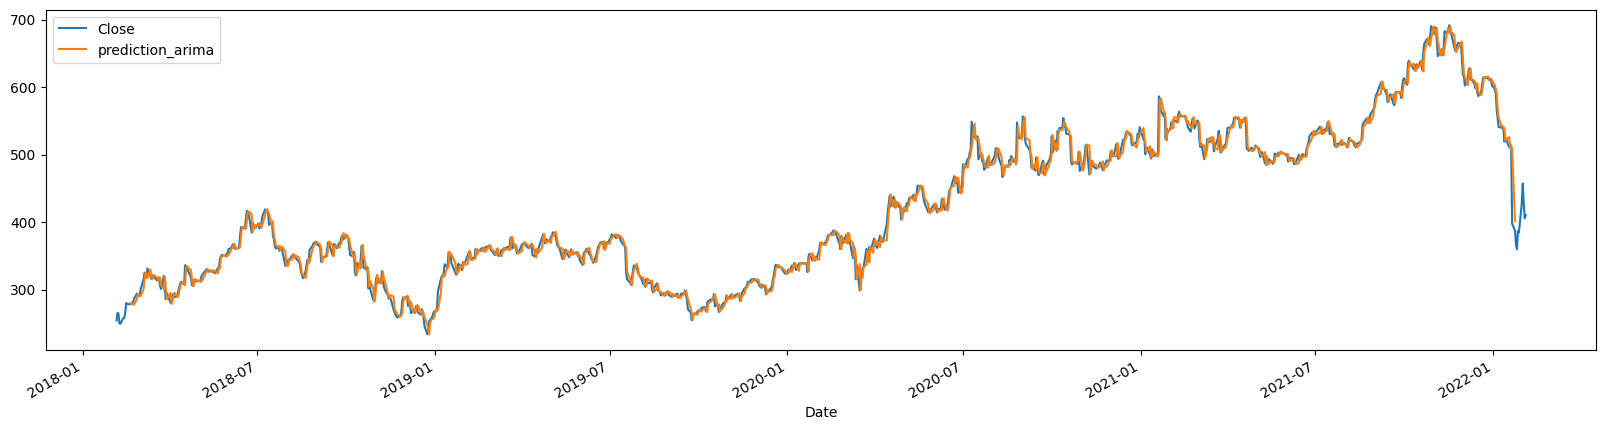

In [14]:
df['prediction_arima']=result.predict(start=10,end=999)
df[["Close","prediction_arima"]].plot(figsize=(20,5))

In [15]:
fc = result.forecast(30, alpha=0.05)
for i in fc:
    print(round(i,0))

409.0
400.0
393.0
392.0
396.0
398.0
398.0
400.0
406.0
411.0
412.0
407.0
404.0
403.0
402.0
398.0
394.0
395.0
399.0
403.0
404.0
405.0
407.0
409.0
408.0
404.0
400.0
399.0
399.0
399.0


In [16]:
fc = [408.0, 408.0, 407.0, 405.0, 411.0, 409.0, 410.0, 407.0, 407.0, 410.0, 409.0, 411.0, 407.0, 408.0, 409.0, 409.0, 410.0, 407.0, 409.0, 409.0, 410.0, 410.0, 408.0, 409.0, 408.0, 410.0, 409.0, 408.0, 409.0, 409.0]

# Create a date range from '2022-02-05' to '2022-03-06'
start_date = '2022-02-05'
end_date = '2022-03-06'
date_range = pd.date_range(start=start_date, end=end_date)


fc_with_dates = pd.Series(fc, index=date_range)
print(fc_with_dates)

2022-02-05    408.0
2022-02-06    408.0
2022-02-07    407.0
2022-02-08    405.0
2022-02-09    411.0
2022-02-10    409.0
2022-02-11    410.0
2022-02-12    407.0
2022-02-13    407.0
2022-02-14    410.0
2022-02-15    409.0
2022-02-16    411.0
2022-02-17    407.0
2022-02-18    408.0
2022-02-19    409.0
2022-02-20    409.0
2022-02-21    410.0
2022-02-22    407.0
2022-02-23    409.0
2022-02-24    409.0
2022-02-25    410.0
2022-02-26    410.0
2022-02-27    408.0
2022-02-28    409.0
2022-03-01    408.0
2022-03-02    410.0
2022-03-03    409.0
2022-03-04    408.0
2022-03-05    409.0
2022-03-06    409.0
Freq: D, dtype: float64


<Axes: >

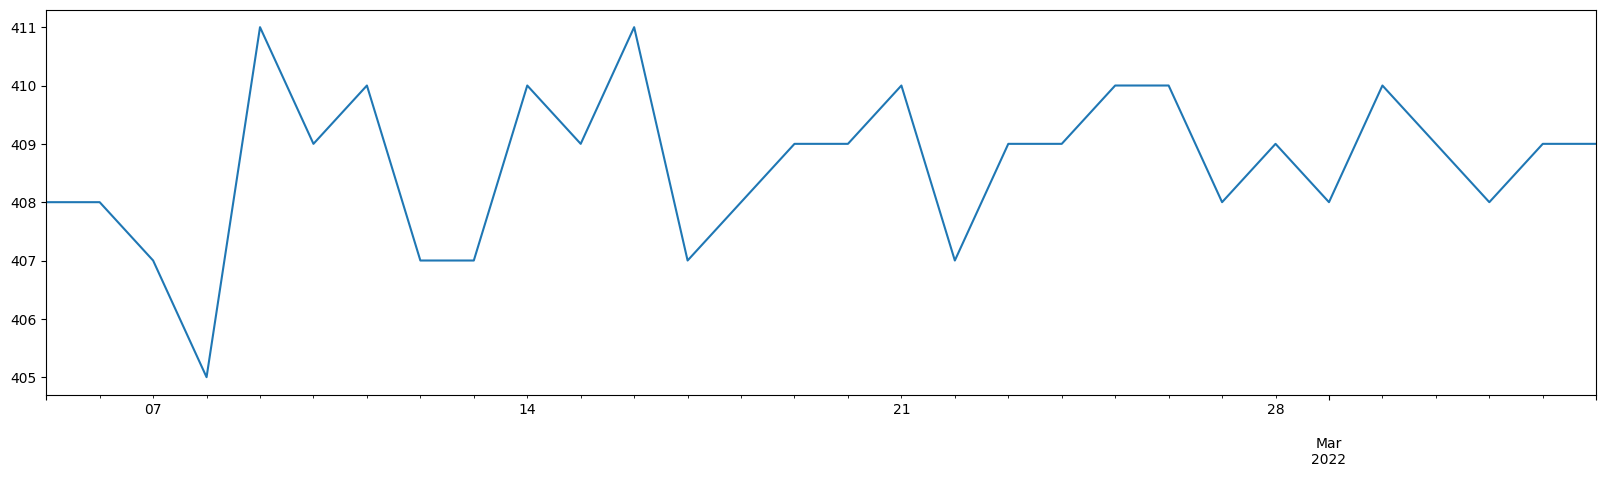

In [17]:
fc_with_dates.plot(figsize=(20,5))

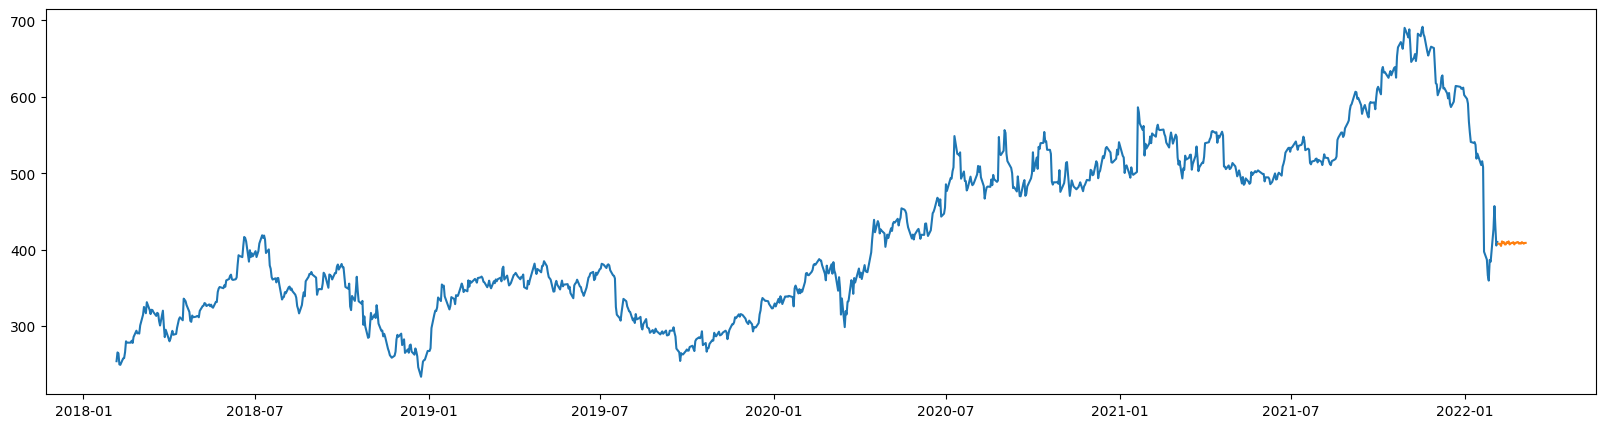

In [18]:
plt.figure(figsize=(20,5))
plt.plot(df["Close"])
plt.plot(fc_with_dates)